In [4]:
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import collections
import cv2
import pandas as pd
from scipy.ndimage import gaussian_filter
import math
from collections import Counter
import matplotlib.pyplot as plt
import re
import csv
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, balanced_accuracy_score
import gc
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

sigmas = [1]
#grid_sizes = [(20, 20), (30, 30), (40, 40),(50, 50), (60, 60)]
grid_sizes = [(30, 30)]
#gaussian_sizes = [(1, 1), (19, 19), (35, 35), (43, 43)]
gaussian_sizes = [(43, 43)]
#batch_sizes = [32, 48, 128, 176]
batch_sizes = [128]
dropouts = [0.5]
#reg_terms = [0.001, 0.0001]
reg_terms = [0.0001]
learning_rates = [1e-3]
patiences = [30]
min_lrs = [1e-6]
factors = [0.2]
#test_sizes = [0.1, 0.15, 0.2]
test_sizes = [0.1]
results_folder = "MODELS COMPARISON"

options =


# Create the folder if it does not exist
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

best_accuracy = 0
best_top3_accuracy = 0
best_f1_accuracy = 0
best_per_class_accuracy = 0
best_balanced_accuracy = 0
best_params = {}
best_params_top3 = {}
best_params_f1 = {}
best_params_per_class = {}
best_params_balanced_accuracy = {}
                                            
distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

current = 0

                                            
                                            

def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.
    
    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h
    
    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)
    
    return horizontal_ppda
                                            
ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)

for test_size in test_sizes:
    for sigma in sigmas:
        for factor in factors:
            for gaussian_size in gaussian_sizes:
                for batch_size in batch_sizes:
                    for dropout in dropouts:
                        for reg_term in reg_terms:
                            for lr in learning_rates:
                                for patience in patiences:
                                    for min_lr in min_lrs:
                                        for grid_size in grid_sizes:

                                            def checkObserverRemembered(observer, image_path, base_dir):
                                                csv_file_path = os.path.join(base_dir, ".." ,"hit_status.csv")
                                                if not os.path.isfile(csv_file_path):
                                                    print("Error: CSV file not found.")
                                                    return False
                                                df = pd.read_csv(csv_file_path)
                                                filtered_rows = df[(df['Setup Folder'] == observer) & (df['Image Path'] == image_path) & (df['Hit'] == 1)]
                                                if not filtered_rows.empty:
                                                    return True
                                                else:
                                                    return False

                                            def bin_fixations(fixation_map):
                                                global grid_size
                                                height, width = fixation_map.shape
                                                binned_map = np.zeros(grid_size)
                                            
                                                bin_height = height // grid_size[0]
                                                bin_width = width // grid_size[1]
                                            
                                                for i in range(grid_size[0]):
                                                    for j in range(grid_size[1]):
                                                        bin_area = fixation_map[i*bin_height:(i+1)*bin_height, j*bin_width:(j+1)*bin_width]
                                                        binned_map[i, j] = np.sum(bin_area)
                                                        #ili avg?
                                            
                                                return binned_map
                                            
                                            def normalize_map(binned_map):
                                                return binned_map / np.sum(binned_map)
                                                #return binned_map
                                            
                                            def smooth_map(binned_map):
                                                global sigma
                                                return gaussian_filter(binned_map, sigma=sigma)
                                            
                                            def process_fixation_map(fixation_map):
                                                binned_map = bin_fixations(fixation_map)
                                                normalized_map = normalize_map(binned_map)
                                                smoothed_map = smooth_map(normalized_map)
                                                return smoothed_map
                                            
                                            def get_current_fixation_map(image_path, coordinates):
                                                image = cv2.imread(image_path)
                                                if image is None:
                                                    print(f"Image at {image_path} not found.")
                                                    return
                                            
                                                coordinates = coordinates[0:120]
                                              
                                                fixation_map = np.zeros((1080, 1920), dtype=np.float32)
                                            
                                                # Convert coordinates to pixel coordinates and update the saliency map
                                                for x_norm, y_norm in coordinates:
                                                    # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
                                                    x = int(((x_norm + 1) / 2 ) * 1920)  # Scaling from (-1, 1) to (0, 1920) range
                                                    y = int((y_norm + 0.5) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
                                                    # Update the saliency map if coordinates are within the screen
                                                    if 0 <= x < 1920 and 0 <= y < 1080:
                                                        fixation_map[y, x] += 1 
                                            
                                            
                                                    '''
                                                    # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
                                                    if(x_norm >0 and y_norm >0):
                                                        x = int((x_norm + 1 + 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
                                                        y = int((y_norm + 0.5 + 0.05) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
                                                    if(x_norm >0 and y_norm <0):
                                                        x = int((x_norm + 1 + 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
                                                        y = int((y_norm + 0.5 - 0.1) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
                                                    if(x_norm <0 and y_norm >0):
                                                        x = int((x_norm + 1 - 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
                                                        y = int((y_norm + 0.5 + 0.05) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
                                                    if(x_norm <0 and y_norm <0):
                                                        x = int((x_norm + 1 - 0.1) * 960)  # Scaling from (-1, 1) to (0, 1920) range
                                                        y = int((y_norm + 0.5 - 0.1) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
                                                    # Update the saliency map if coordinates are within the screen
                                                    if 0 <= x < 1920 and 0 <= y < 1080:
                                                        fixation_map[y, x] += 1'''
                                                #sigma = ppda / np.sqrt(2)
                                                #fixation_map = gaussian_filter(fixation_map, sigma = sigma)
                                                fixation_map = cv2.GaussianBlur(fixation_map, gaussian_size, 0)
                                                # Crop the saliency map to the 700x700 region
                                                fixation_map = fixation_map[190:890, 610:1310]
                                                # flip the Y coordinates
                                                fixation_map = np.flipud(fixation_map)
                                                return fixation_map
                                            
                                            def normalize_fixation_map(fixation_map):
                                                min_val = np.min(fixation_map)
                                                max_val = np.max(fixation_map)
                                                normalized_fixation_map = (fixation_map - min_val) / (max_val - min_val) * 255
                                                return normalized_fixation_map
                                            
                                            # 90experiments folder
                                            base_dir = os.path.abspath(os.path.join(os.getcwd(),"..", "..", "90experiments"))
                                            
                                            fixation_maps = {}  # Dictionary to store fixation maps for each imagePath
                                            
                                            
                                            for folder in os.listdir(base_dir):
                                                folder_path = os.path.join(base_dir, folder)
                                                if not os.path.isdir(folder_path):
                                                    continue
                                                match = re.search(r'\d{1,2}$', folder)
                                                if match:
                                                    observer = int(match.group())
                                                #if(observer != 5):
                                                #    continue
                                                if(observer == 1 or observer == 2 or observer == 49 or observer == 50 or observer == 5):
                                                    continue
                                            
                                                #if(observer not in [70,71,73,74,76,77,79,80,82,83,85,87,88,89,86,90,18,57,6,45,48,60,63,69,3,9,12,21,15,27,30,33,36,42,24,66,51,54,72,75]):
                                                #    continue
                                                    
                                                csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
                                                if not os.path.isfile(csv_file_path):
                                                    continue
                                                data = pd.read_csv(csv_file_path)
                                            
                                                filtered_data = data[data['ImagePath'].str.startswith('targetImages')]
                                                
                                                uniqueImagePaths = []
                                                delete_rows = []
                                            
                                                #get only the eye-tracking data from the first viewing
                                                index = 0
                                                
                                                row = filtered_data.iloc[index]
                                                while len(uniqueImagePaths) < 10:
                                                    row = filtered_data.iloc[index]
                                                    if(row['ImagePath'] not in uniqueImagePaths):
                                                        uniqueImagePaths.append(row['ImagePath'])
                                                        lastImagePath = row['ImagePath']
                                                        index +=1
                                                    elif(row['ImagePath'] in uniqueImagePaths):
                                                        index += 1    
                                                row = filtered_data.iloc[index]
                                            
                                                while(row['ImagePath'] == lastImagePath):
                                                    index +=1
                                                    row = filtered_data.iloc[index]
                                            
                                                filtered_data.reset_index(drop=True, inplace=True)
                                                filtered_data = filtered_data.iloc[:index].copy()
                                                
                                                grouped = filtered_data.groupby('ImagePath')
                                            
                                                # Generate and save fixation maps for each image in the current folder
                                                for image_path, group in grouped:
                                                    # Construct full image path by going one directory back from base_dir
                                                    full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))
                                                    full_image_path = full_image_path.replace('\\', '/')
                                            
                                                    #check if current observer has remembered this image, if not, continue
                                                    if(not checkObserverRemembered(observer, image_path, base_dir)):
                                                        continue
                                                    
                                                    # Extract coordinates
                                                    coordinates = group[['PosX', 'PosY']].values
                                            
                                                    current_fixation_map = get_current_fixation_map (full_image_path, coordinates)
                                                    if(np.all(current_fixation_map == 0)):
                                                        continue
                                            
                                                    current_fixation_map_20x20 = process_fixation_map(current_fixation_map)
                                                    current_fixation_map_20x20 = normalize_fixation_map(current_fixation_map_20x20)
                                                    
                                                    #current_fixation_map_20x20 = (current_fixation_map)
                                                    #add to dictionary or update it
                                                    if image_path not in fixation_maps:
                                                        fixation_maps[image_path] = [current_fixation_map_20x20]
                                                    else:
                                                        fixation_maps[image_path].append(current_fixation_map_20x20)
                                                        
                                            # Flatten the fixation maps and standardize them
                                            all_fixation_maps = []
                                            labels = []
                                            
                                            for image_path, maps in fixation_maps.items():
                                                for fixation_map in maps:
                                                    all_fixation_maps.append(fixation_map.flatten())
                                                    labels.append(image_path)
                                            
                                            X = np.array(all_fixation_maps)
                                            y = np.array(labels)
      
                                            #training
                                            from tensorflow.keras.models import Sequential
                                            from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
                                            from tensorflow.keras.optimizers import Adam
                                            from tensorflow.keras.preprocessing.image import ImageDataGenerator
                                            from sklearn.metrics import classification_report, accuracy_score
                                            from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
                                            from tensorflow.keras.regularizers import l2
                                            from imblearn.over_sampling import SMOTE
                                            import collections
                                            import numpy as np
                                            import matplotlib.pyplot as plt
                                            import json
                                            
                                            trainings = 15
                                            
                                            for i in range(trainings):
                                                X = X.reshape(-1, grid_size[0], grid_size[1], 1)
                                            
                                                label_encoder = LabelEncoder()
                                                y_encoded = label_encoder.fit_transform(y)
                                                label_names = label_encoder.classes_
                                                
                                                X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, stratify=y_encoded)
                                                
                                                y_train_categorical = to_categorical(y_train, num_classes=len(label_encoder.classes_))
                                                y_test_categorical = to_categorical(y_test, num_classes=len(label_encoder.classes_))
                                                
                                                '''
                                                # Flatten X_train for SMOTE
                                                X_train_flatten = X_train.reshape(X_train.shape[0], -1)
                                                
                                                # Apply SMOTE to balance the dataset
                                                smote = SMOTE()
                                                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flatten, np.argmax(y_train_categorical, axis=1))
                                                
                                                # Reshape X_train back to original shape
                                                X_train_resampled = X_train_resampled.reshape(-1, grid_size[0], grid_size[1], 1)
                                                y_train_resampled_categorical = np.eye(len(label_encoder.classes_))[y_train_resampled]
                                                
                                                # Calculate class weights
                                                class_counts = collections.Counter(np.argmax(y_train_resampled_categorical, axis=1))
                                                total_samples = sum(class_counts.values())
                                                class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
                                                #print("Class counts:", class_counts)
                                                #print("Class weights:", class_weights)
                                                '''
                                                # Define the MLP model
                                                
                                                model = Sequential([
                                                    Input(shape=(grid_size[0], grid_size[1], 1)),
                                                    Flatten(),
                                                    Dense(512, activation='relu', kernel_regularizer=l2(reg_term)),
                                                    BatchNormalization(),
                                                    Dropout(dropout),
                                                    Dense(256, activation='relu', kernel_regularizer=l2(reg_term)),
                                                    BatchNormalization(),
                                                    Dropout(dropout),
                                                    Dense(len(label_encoder.classes_), activation='softmax')
                                                ])
                                                '''input_size = (32, 32)
                                                X_train = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)) for img in X_train])
                                                X_test = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)) for img in X_test])

                                                base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

                                                model = Sequential([
                                                    base_model,
                                                    GlobalAveragePooling2D(),
                                                    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
                                                    Dropout(0.5),
                                                    Dense(len(label_encoder.classes_), activation='softmax')
                                                ])'''
                                                
                                                # Compile the model
                                                model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
                                                
                                                # Callbacks for learning rate adjustment and early stopping
                                                reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, min_lr=min_lr)
                                                early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
                                                model_checkpoint = ModelCheckpoint(os.path.join(results_folder, 'best_model_brute_force.keras'), monitor='val_accuracy', save_best_only=True, mode='max')
                                                
                                                
                                                # Train the model
                                                history = model.fit(X_train, y_train_categorical,
                                                                    validation_data=(X_test, y_test_categorical),
                                                                    epochs=1000,
                                                                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                                                                    #class_weight=class_weights,
                                                                    batch_size = batch_size,
                                                                    verbose = 0
                                                                    )
                                                
                                                # Evaluate the model
                                                y_pred_prob = model.predict(X_test, verbose = 0)
                                                y_pred = np.argmax(y_pred_prob, axis=1)
                                                
                                                # Calculate accuracy
                                                accuracy = accuracy_score(y_test, y_pred)
                                                top_3_accuracy = history.history['val_top_k_categorical_accuracy'][-1]
                                                f1 = f1_score(y_test, y_pred, average='macro')  # You can use 'micro' or 'weighted' based on your needs
                                                conf_matrix = confusion_matrix(y_test, y_pred)
                                                per_class_accuracy = np.mean(conf_matrix.diagonal() / conf_matrix.sum(axis=1))
                                                balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
                                                    
                                                if(accuracy > best_accuracy):
                                                    best_accuracy = accuracy
                                                    best_params = {
                                                                   'sigma':sigma, 
                                                                   'grid_size':grid_size, 
                                                                   'gaussian_size':gaussian_size,
                                                                   'batch_size':batch_size,
                                                                   'dropout':dropout,
                                                                   'reg_term':reg_term,
                                                                   'lr':lr,
                                                                   'patience':patience,
                                                                   'min_lr':min_lr,
                                                                   'factor':factor,
                                                                   'test_size': test_size}
                                                    print("Newest best accuracy: ", best_accuracy)
                                                    print("Params: ", best_params)
                                                    # Save the best model, accuracy and top-3 accuracy
                                                    with open(os.path.join(results_folder, "best_accuracy_MLP_search_accuracy.txt"), "w") as f:
                                                        f.write(f"Best accuracy: {best_accuracy:.4f}\n")
                                                        f.write("Best parameters:\n")
                                                        f.write(json.dumps(best_params, indent=4))
                                                    # Define the path to save the model
                                                    model_save_path = os.path.join(results_folder, 'best_model.keras')
                                                    # Save the model
                                                    model.save(model_save_path)
                                                        
                                                if(top_3_accuracy > best_top3_accuracy):
                                                    best_top3_accuracy = top_3_accuracy
                                                    best_params_top3 = {
                                                                   'sigma':sigma, 
                                                                   'grid_size':grid_size, 
                                                                   'gaussian_size':gaussian_size,
                                                                   'batch_size':batch_size,
                                                                   'dropout':dropout,
                                                                   'reg_term':reg_term,
                                                                   'lr':lr,
                                                                   'patience':patience,
                                                                   'min_lr':min_lr,
                                                                   'factor':factor,
                                                                   'test_size': test_size}
                                                    print("Newest top3 best accuracy: ", best_top3_accuracy)
                                                    print("Params top3: ", best_params_top3)
                                                    # Save the best model, accuracy and top-3 accuracy
                                                    with open(os.path.join(results_folder, "best_accuracy_MLP_search_top3_accuracy.txt"), "w") as f:
                                                        f.write(f"Top 3 accuracy: {best_top3_accuracy:.4f}\n")
                                                        f.write("Best top3 parameters:\n")
                                                        f.write(json.dumps(best_params_top3, indent=4))
                                                    # Define the path to save the model
                                                    model_save_path = os.path.join(results_folder, 'top3_model.keras')
                                                    # Save the model
                                                    model.save(model_save_path)

                                                if(f1 > best_f1_accuracy):
                                                    best_f1_accuracy = f1
                                                    best_params_f1 = {
                                                                   'sigma':sigma, 
                                                                   'grid_size':grid_size, 
                                                                   'gaussian_size':gaussian_size,
                                                                   'batch_size':batch_size,
                                                                   'dropout':dropout,
                                                                   'reg_term':reg_term,
                                                                   'lr':lr,
                                                                   'patience':patience,
                                                                   'min_lr':min_lr,
                                                                   'factor':factor,
                                                                   'test_size': test_size}
                                                    print("Newest f1 best accuracy: ", best_f1_accuracy)
                                                    print("Params f1: ", best_params_f1)
                                                    # Save the best model, accuracy and top-3 accuracy
                                                    with open(os.path.join(results_folder, "best_accuracy_MLP_search_f1_accuracy.txt"), "w") as f:
                                                        f.write(f"Top f1 accuracy: {best_f1_accuracy:.4f}\n")
                                                        f.write("Best f1 parameters:\n")
                                                        f.write(json.dumps(best_params_f1, indent=4))
                                                    # Define the path to save the model
                                                    model_save_path = os.path.join(results_folder, 'f1_model.keras')
                                                    # Save the model
                                                    model.save(model_save_path)

                                                if(per_class_accuracy > best_per_class_accuracy):
                                                    best_per_class_accuracy = per_class_accuracy
                                                    best_params_per_class = {
                                                                   'sigma':sigma, 
                                                                   'grid_size':grid_size, 
                                                                   'gaussian_size':gaussian_size,
                                                                   'batch_size':batch_size,
                                                                   'dropout':dropout,
                                                                   'reg_term':reg_term,
                                                                   'lr':lr,
                                                                   'patience':patience,
                                                                   'min_lr':min_lr,
                                                                   'factor':factor,
                                                                   'test_size': test_size}
                                                    print("Newest per class best accuracy: ", best_per_class_accuracy)
                                                    print("Params per class: ", best_params_per_class)
                                                    # Save the best model, accuracy and top-3 accuracy
                                                    with open(os.path.join(results_folder, "best_accuracy_MLP_search_per_class_accuracy.txt"), "w") as f:
                                                        f.write(f"Top per_class accuracy: {best_per_class_accuracy:.4f}\n")
                                                        f.write("Best per class parameters:\n")
                                                        f.write(json.dumps(best_params_per_class, indent=4))
                                                    # Define the path to save the model
                                                    model_save_path = os.path.join(results_folder, 'per_class_model.keras')
                                                    # Save the model
                                                    model.save(model_save_path)

                                                if(balanced_accuracy > best_balanced_accuracy):
                                                    best_balanced_accuracy = balanced_accuracy
                                                    best_params_balanced = {
                                                                   'sigma':sigma, 
                                                                   'grid_size':grid_size, 
                                                                   'gaussian_size':gaussian_size,
                                                                   'batch_size':batch_size,
                                                                   'dropout':dropout,
                                                                   'reg_term':reg_term,
                                                                   'lr':lr,
                                                                   'patience':patience,
                                                                   'min_lr':min_lr,
                                                                   'factor':factor,
                                                                   'test_size': test_size}
                                                    print("Newest balanced best accuracy: ", best_balanced_accuracy)
                                                    print("Params balanced accuracy: ", best_params_balanced)
                                                    # Save the best model, accuracy and top-3 accuracy
                                                    with open(os.path.join(results_folder, "best_accuracy_MLP_search_balanced_accuracy.txt"), "w") as f:
                                                        f.write(f"Top balanced accuracy: {best_balanced_accuracy:.4f}\n")
                                                        f.write("Best balanced accuracy parameters:\n")
                                                        f.write(json.dumps(best_params_balanced, indent=4))
                                                    # Define the path to save the model
                                                    model_save_path = os.path.join(results_folder, 'balanced_accuracy_model.keras')
                                                    # Save the model
                                                    model.save(model_save_path)
                                                current += 1
                                                print("Current: ", current)
                                            # Clear large data structures
                                            del fixation_maps, all_fixation_maps, X, y
                                            gc.collect()
                                            
                                            # Clear Keras session state
                                            tf.keras.backend.clear_session()

                                            # Additionally, delete the model and history to ensure they don't consume memory
                                            del model, history, X_train, X_test, y_train, y_test, y_train_categorical, y_test_categorical, y_pred_prob, y_pred, conf_matrix
                                            gc.collect()


print("FINAL Best accuracy: ", best_accuracy)
print("FINAL Params: ", best_params)


Newest best accuracy:  0.42857142857142855
Params:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size': (43, 43), 'batch_size': 128, 'dropout': 0.5, 'reg_term': 0.0001, 'lr': 0.001, 'patience': 30, 'min_lr': 1e-06, 'factor': 0.2, 'test_size': 0.1}
Newest top3 best accuracy:  0.60317462682724
Params top3:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size': (43, 43), 'batch_size': 128, 'dropout': 0.5, 'reg_term': 0.0001, 'lr': 0.001, 'patience': 30, 'min_lr': 1e-06, 'factor': 0.2, 'test_size': 0.1}
Newest f1 best accuracy:  0.3903174603174603
Params f1:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size': (43, 43), 'batch_size': 128, 'dropout': 0.5, 'reg_term': 0.0001, 'lr': 0.001, 'patience': 30, 'min_lr': 1e-06, 'factor': 0.2, 'test_size': 0.1}
Newest per class best accuracy:  0.41111111111111115
Params per class:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size': (43, 43), 'batch_size': 128, 'dropout': 0.5, 'reg_term': 0.0001, 'lr': 0.001, 'patience': 30, 'min_lr': 1e-06, 'fact

Newest best accuracy:  0.3333333333333333
Params:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size': (43, 43), 'batch_size': 128, 'dropout': 0.5, 'reg_term': 0.0001, 'lr': 0.001, 'patience': 30, 'min_lr': 1e-06, 'factor': 0.2, 'test_size': 0.1, 'model': 'svm'}
Newest f1 best accuracy:  0.2502380952380952
Params f1:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size': (43, 43), 'batch_size': 128, 'dropout': 0.5, 'reg_term': 0.0001, 'lr': 0.001, 'patience': 30, 'min_lr': 1e-06, 'factor': 0.2, 'test_size': 0.1, 'model': 'svm'}
Newest per class best accuracy:  0.2944444444444444
Params per class:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size': (43, 43), 'batch_size': 128, 'dropout': 0.5, 'reg_term': 0.0001, 'lr': 0.001, 'patience': 30, 'min_lr': 1e-06, 'factor': 0.2, 'test_size': 0.1, 'model': 'svm'}
Newest balanced best accuracy:  0.2944444444444444
Params balanced accuracy:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size': (43, 43), 'batch_size': 128, 'dropout': 0.5, 'reg_t

C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  121


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  122


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  123


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  124


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  125


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  126


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  127


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  128


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  129


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  130


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  131


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  132


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  133


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  134


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  135


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  136


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  137


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  138


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  139


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  140


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  141


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  142


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  143


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  144


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  145


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  146


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  147


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  148


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  149


C:\Users\valerijan\AppData\Local\Temp\ipykernel_9880\4159604467.py:400: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Current:  150
Current:  151
Current:  152
Current:  153
Current:  154
Current:  155
Current:  156
Current:  157
Current:  158
Current:  159
Current:  160
Current:  161
Current:  162
Current:  163
Current:  164
Current:  165
Newest top3 best accuracy:  1.0
Params top3:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size': (43, 43), 'batch_size': 128, 'dropout': 0.5, 'reg_term': 0.0001, 'lr': 0.001, 'patience': 30, 'min_lr': 1e-06, 'factor': 0.2, 'test_size': 0.1, 'model': 'resnet'}
Current:  166
Current:  167
Current:  168
Current:  169
Current:  170
Current:  171
Current:  172
Current:  173
Current:  174
Current:  175
Current:  176
Current:  177
Current:  178
Current:  179
Current:  180
Current:  181
Current:  182
Current:  183
Current:  184
Current:  185
Current:  186
Current:  187
Current:  188
Current:  189
Current:  190
Current:  191
Current:  192
Current:  193
Current:  194
Newest f1 best accuracy:  0.5753968253968255
Params f1:  {'sigma': 1, 'grid_size': (30, 30), 'gaussian_size'

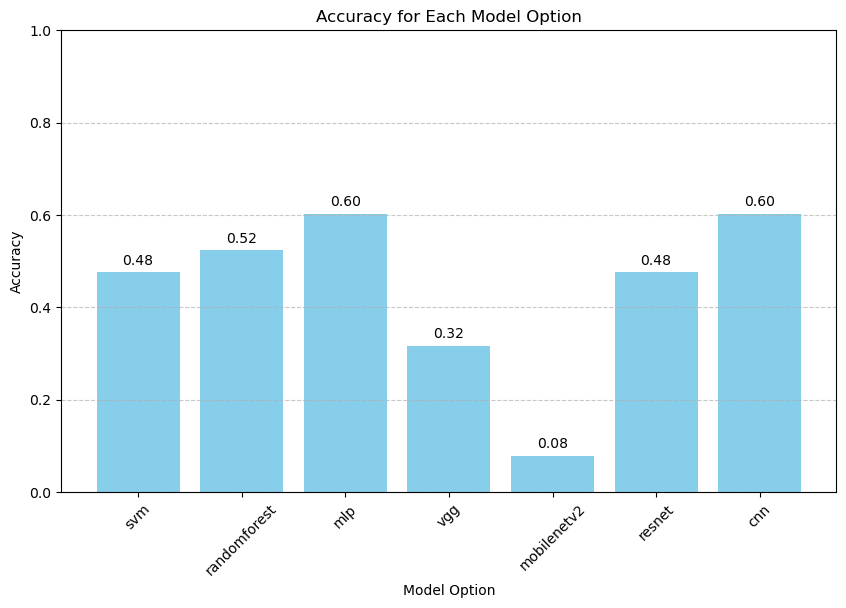

In [7]:
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import collections
import cv2
import pandas as pd
from scipy.ndimage import gaussian_filter
import math
from collections import Counter
import matplotlib.pyplot as plt
import re
import csv
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, balanced_accuracy_score
import gc
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

sigmas = [1]
#grid_sizes = [(20, 20), (30, 30), (40, 40),(50, 50), (60, 60)]
grid_sizes = [(30, 30)]
#gaussian_sizes = [(1, 1), (19, 19), (35, 35), (43, 43)]
gaussian_sizes = [(43, 43)]
#batch_sizes = [32, 48, 128, 176]
batch_sizes = [128]
dropouts = [0.5]
#reg_terms = [0.001, 0.0001]
reg_terms = [0.0001]
learning_rates = [1e-3]
patiences = [30]
min_lrs = [1e-6]
factors = [0.2]
#test_sizes = [0.1, 0.15, 0.2]
test_sizes = [0.1]
results_folder = "models comparison all"

options = ["svm", "randomforest", "mlp", "vgg", "mobilenetv2", "resnet", "cnn"]
#options = ["randomforest", "svm"]
model_accuracies = {}

# Create the folder if it does not exist
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# 90experiments folder
base_dir = os.path.abspath(os.path.join(os.getcwd(),"..","..", "90experiments"))

best_accuracy = 0
best_top3_accuracy = 0
best_f1_accuracy = 0
best_per_class_accuracy = 0
best_balanced_accuracy = 0
best_params = {}
best_params_top3 = {}
best_params_f1 = {}
best_params_per_class = {}
best_params_balanced_accuracy = {}
                                            
distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

current = 0

                                            
                                            

def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.
    
    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h
    
    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)
    
    return horizontal_ppda
                                            
ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)

for option in options:
    for test_size in test_sizes:
        for sigma in sigmas:
            for factor in factors:
                for gaussian_size in gaussian_sizes:
                    for batch_size in batch_sizes:
                        for dropout in dropouts:
                            for reg_term in reg_terms:
                                for lr in learning_rates:
                                    for patience in patiences:
                                        for min_lr in min_lrs:
                                            for grid_size in grid_sizes:
    
                                                def checkObserverRemembered(observer, image_path, base_dir):
                                                    csv_file_path = os.path.join(base_dir, ".." ,"hit_status.csv")
                                                    if not os.path.isfile(csv_file_path):
                                                        print("Error: CSV file not found.")
                                                        return False
                                                    df = pd.read_csv(csv_file_path)
                                                    filtered_rows = df[(df['Setup Folder'] == observer) & (df['Image Path'] == image_path) & (df['Hit'] == 1)]
                                                    if not filtered_rows.empty:
                                                        return True
                                                    else:
                                                        return False
    
                                                def bin_fixations(fixation_map):
                                                    global grid_size
                                                    height, width = fixation_map.shape
                                                    binned_map = np.zeros(grid_size)
                                                
                                                    bin_height = height // grid_size[0]
                                                    bin_width = width // grid_size[1]
                                                
                                                    for i in range(grid_size[0]):
                                                        for j in range(grid_size[1]):
                                                            bin_area = fixation_map[i*bin_height:(i+1)*bin_height, j*bin_width:(j+1)*bin_width]
                                                            binned_map[i, j] = np.sum(bin_area)
                                                            #ili avg?
                                                
                                                    return binned_map
                                                
                                                def normalize_map(binned_map):
                                                    return binned_map / np.sum(binned_map)
                                                    #return binned_map
                                                
                                                def smooth_map(binned_map):
                                                    global sigma
                                                    return gaussian_filter(binned_map, sigma=sigma)
                                                
                                                def process_fixation_map(fixation_map):
                                                    binned_map = bin_fixations(fixation_map)
                                                    normalized_map = normalize_map(binned_map)
                                                    smoothed_map = smooth_map(normalized_map)
                                                    return smoothed_map
                                                
                                                def get_current_fixation_map(image_path, coordinates):
                                                    image = cv2.imread(image_path)
                                                    if image is None:
                                                        print(f"Image at {image_path} not found.")
                                                        return
                                                
                                                    coordinates = coordinates[0:120]
                                                  
                                                    fixation_map = np.zeros((1080, 1920), dtype=np.float32)
                                                
                                                    # Convert coordinates to pixel coordinates and update the saliency map
                                                    for x_norm, y_norm in coordinates:
                                                        # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
                                                        x = int(((x_norm + 1) / 2 ) * 1920)  # Scaling from (-1, 1) to (0, 1920) range
                                                        y = int((y_norm + 0.5) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
                                                        # Update the saliency map if coordinates are within the screen
                                                        if 0 <= x < 1920 and 0 <= y < 1080:
                                                            fixation_map[y, x] += 1 

                                                    fixation_map = cv2.GaussianBlur(fixation_map, gaussian_size, 0)
                                                    # Crop the saliency map to the 700x700 region
                                                    fixation_map = fixation_map[190:890, 610:1310]
                                                    # flip the Y coordinates
                                                    fixation_map = np.flipud(fixation_map)
                                                    return fixation_map
                                                
                                                def normalize_fixation_map(fixation_map):
                                                    min_val = np.min(fixation_map)
                                                    max_val = np.max(fixation_map)
                                                    normalized_fixation_map = (fixation_map - min_val) / (max_val - min_val) * 255
                                                    return normalized_fixation_map
                                                
                                                
                                                
                                                fixation_maps = {}  # Dictionary to store fixation maps for each imagePath
                                                
                                                
                                                for folder in os.listdir(base_dir):
                                                    folder_path = os.path.join(base_dir, folder)
                                                    if not os.path.isdir(folder_path):
                                                        continue
                                                    match = re.search(r'\d{1,2}$', folder)
                                                    if match:
                                                        observer = int(match.group())

                                                    if(observer == 1 or observer == 2 or observer == 49 or observer == 50 or observer == 5):
                                                        continue

                                                    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
                                                    if not os.path.isfile(csv_file_path):
                                                        continue
                                                    data = pd.read_csv(csv_file_path)
                                                
                                                    filtered_data = data[data['ImagePath'].str.startswith('targetImages')]
                                                    
                                                    uniqueImagePaths = []
                                                    delete_rows = []
                                                
                                                    #get only the eye-tracking data from the first viewing
                                                    index = 0
                                                    
                                                    row = filtered_data.iloc[index]
                                                    while len(uniqueImagePaths) < 10:
                                                        row = filtered_data.iloc[index]
                                                        if(row['ImagePath'] not in uniqueImagePaths):
                                                            uniqueImagePaths.append(row['ImagePath'])
                                                            lastImagePath = row['ImagePath']
                                                            index +=1
                                                        elif(row['ImagePath'] in uniqueImagePaths):
                                                            index += 1    
                                                    row = filtered_data.iloc[index]
                                                
                                                    while(row['ImagePath'] == lastImagePath):
                                                        index +=1
                                                        row = filtered_data.iloc[index]
                                                
                                                    filtered_data.reset_index(drop=True, inplace=True)
                                                    filtered_data = filtered_data.iloc[:index].copy()
                                                    
                                                    grouped = filtered_data.groupby('ImagePath')
                                                
                                                    # Generate and save fixation maps for each image in the current folder
                                                    for image_path, group in grouped:
                                                        # Construct full image path by going one directory back from base_dir
                                                        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))
                                                        full_image_path = full_image_path.replace('\\', '/')
                                                
                                                        #check if current observer has remembered this image, if not, continue
                                                        if(not checkObserverRemembered(observer, image_path, base_dir)):
                                                            continue
                                                        
                                                        # Extract coordinates
                                                        coordinates = group[['PosX', 'PosY']].values
                                                
                                                        current_fixation_map = get_current_fixation_map (full_image_path, coordinates)
                                                        if(np.all(current_fixation_map == 0)):
                                                            continue
                                                
                                                        current_fixation_map_20x20 = process_fixation_map(current_fixation_map)
                                                        current_fixation_map_20x20 = normalize_fixation_map(current_fixation_map_20x20)
                                                        
                                                        #current_fixation_map_20x20 = (current_fixation_map)
                                                        #add to dictionary or update it
                                                        if image_path not in fixation_maps:
                                                            fixation_maps[image_path] = [current_fixation_map_20x20]
                                                        else:
                                                            fixation_maps[image_path].append(current_fixation_map_20x20)
                                                            
                                                # Flatten the fixation maps and standardize them
                                                all_fixation_maps = []
                                                labels = []
                                                
                                                for image_path, maps in fixation_maps.items():
                                                    for fixation_map in maps:
                                                        all_fixation_maps.append(fixation_map.flatten())
                                                        labels.append(image_path)
                                                
                                                X = np.array(all_fixation_maps)
                                                y = np.array(labels)
          
                                                #training
                                                from keras.applications import VGG16, MobileNetV2
                                                from tensorflow.keras.models import Sequential
                                                from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
                                                from tensorflow.keras.optimizers import Adam
                                                from tensorflow.keras.preprocessing.image import ImageDataGenerator
                                                from sklearn.metrics import classification_report, accuracy_score
                                                from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
                                                from tensorflow.keras.regularizers import l2
                                                from imblearn.over_sampling import SMOTE
                                                import collections
                                                import numpy as np
                                                import matplotlib.pyplot as plt
                                                import json
                                                from sklearn.svm import SVC
                                                from sklearn.ensemble import RandomForestClassifier
                                                from sklearn.preprocessing import LabelEncoder
                                                from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score
                                                from keras.preprocessing.image import img_to_array, array_to_img
                                                import joblib 

    
                                                def save_model(model, model_save_path, option):
                                                    # Check if the model is a Keras model by checking if it has a 'save' method
                                                    if hasattr(model, 'save'):
                                                        model.save(model_save_path)
                                                    else:
                                                        # For scikit-learn models, use joblib to save
                                                        joblib.dump(model, model_save_path)
                                                
                                                trainings = 30
                                                
                                                for i in range(trainings):
                                                    X = X.reshape(-1, grid_size[0], grid_size[1], 1)
                                                
                                                    label_encoder = LabelEncoder()
                                                    y_encoded = label_encoder.fit_transform(y)
                                                    label_names = label_encoder.classes_
                                                    
                                                    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, stratify=y_encoded)
                                                    
                                                    y_train_categorical = to_categorical(y_train, num_classes=len(label_encoder.classes_))
                                                    y_test_categorical = to_categorical(y_test, num_classes=len(label_encoder.classes_))


                                                    if(option == "mlp"):
                                                        # Define the MLP model
                                                        model = Sequential([
                                                            Input(shape=(grid_size[0], grid_size[1], 1)),
                                                            Flatten(),
                                                            Dense(512, activation='relu', kernel_regularizer=l2(reg_term)),
                                                            BatchNormalization(),
                                                            Dropout(dropout),
                                                            Dense(256, activation='relu', kernel_regularizer=l2(reg_term)),
                                                            BatchNormalization(),
                                                            Dropout(dropout),
                                                            Dense(len(label_encoder.classes_), activation='softmax')
                                                        ])

                                                    elif(option == "cnn"):
                                                        # Define the CNN model
                                                        model = Sequential([
                                                            Input(shape=(grid_size[0], grid_size[1], 1)),
                                                            Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(reg_term)),
                                                            BatchNormalization(),
                                                            MaxPooling2D(pool_size=(2, 2)),
                                                            Dropout(dropout),
                                                            
                                                            Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg_term)),
                                                            BatchNormalization(),
                                                            MaxPooling2D(pool_size=(2, 2)),
                                                            Dropout(dropout),
                    
                                                            Flatten(),
                                                            Dense(256, activation='relu', kernel_regularizer=l2(reg_term)),
                                                            BatchNormalization(),
                                                            Dropout(dropout),
                                                            
                                                            Dense(len(label_encoder.classes_), activation='softmax')
                                                        ])
                                                    elif(option == "resnet"):
                                                        
                                                        input_size = (32, 32)
                                                        X_train = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)) for img in X_train])
                                                        X_test = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)) for img in X_test])
        
                                                        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
        
                                                        model = Sequential([
                                                            base_model,
                                                            GlobalAveragePooling2D(),
                                                            Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
                                                            Dropout(0.5),
                                                            Dense(len(label_encoder.classes_), activation='softmax')
                                                        ])
                                                    elif(option == "vgg"):
                                                        # Define the input size
                                                        input_size = (32, 32)
                                                        
                                                        # Convert X_train and X_test to have 3 channels and resize them
                                                        X_train = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)) for img in X_train])
                                                        X_test = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)) for img in X_test])
                                                        
                                                        # Load the VGG16 model without the top layers and specify input shape
                                                        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
                                                        
                                                        # Build the sequential model
                                                        model = Sequential([
                                                            base_model,
                                                            GlobalAveragePooling2D(),
                                                            Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
                                                            Dropout(0.5),
                                                            Dense(len(label_encoder.classes_), activation='softmax')
                                                        ])

                                                    elif(option == "mobilenetv2"):
                                                        # Define the input size
                                                        input_size = (32, 32)
                                                        
                                                        # Convert X_train and X_test to have 3 channels and resize them
                                                        X_train = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)) for img in X_train])
                                                        X_test = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)) for img in X_test])
                                                        
                                                        # Load the MobileNetV2 model without the top layers and specify input shape
                                                        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
                                                        
                                                        # Build the sequential model
                                                        model = Sequential([
                                                            base_model,
                                                            GlobalAveragePooling2D(),
                                                            Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
                                                            Dropout(0.5),
                                                            Dense(len(label_encoder.classes_), activation='softmax')
                                                        ])
                                                    elif option == "svm":
                                                        input_size = (32, 32)
                                                        X_train_flat = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)).flatten() for img in X_train])
                                                        X_test_flat = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)).flatten() for img in X_test])
                                                    
                                                        label_encoder = LabelEncoder()
                                                        y_train_encoded = label_encoder.fit_transform(y_train)
                                                        y_test_encoded = label_encoder.transform(y_test)
                                                    
                                                        model = SVC(kernel='linear', C=1.0, probability=True)
                                                        model.fit(X_train_flat, y_train_encoded)
                                                    
                                                        # Predictions
                                                        y_pred_prob = model.predict_proba(X_test_flat)
                                                        y_pred = model.predict(X_test_flat)
                                                    
                                                    elif option == "randomforest":
                                                        input_size = (32, 32)
                                                        X_train_flat = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)).flatten() for img in X_train])
                                                        X_test_flat = np.array([img_to_array(array_to_img(np.repeat(img, 3, axis=2)).resize(input_size)).flatten() for img in X_test])
                                                    
                                                        label_encoder = LabelEncoder()
                                                        y_train_encoded = label_encoder.fit_transform(y_train)
                                                        y_test_encoded = label_encoder.transform(y_test)
                                                    
                                                        model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
                                                        model.fit(X_train_flat, y_train_encoded)
                                                    
                                                        # Predictions
                                                        y_pred_prob = model.predict_proba(X_test_flat)
                                                        y_pred = model.predict(X_test_flat)
                                                    
                                                    elif option == "rusboost":
                                                        # Placeholder for RUSBoost implementation
                                                        # Implement as needed for your specific case
                                                        pass
                                                    
                                                    # Compile the model only for neural networks
                                                    if option in ["mlp", "resnet", "vgg", "mobilenetv2", "cnn"]:
                                                        model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy',
                                                                      metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
                                                    
                                                        # Callbacks for learning rate adjustment and early stopping
                                                        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, min_lr=min_lr)
                                                        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
                                                        model_checkpoint = ModelCheckpoint(os.path.join(results_folder, 'best_model_brute_force.keras'), monitor='val_accuracy', save_best_only=True, mode='max')
                                                    
                                                        # Train the model
                                                        history = model.fit(X_train, y_train_categorical,
                                                                            validation_data=(X_test, y_test_categorical),
                                                                            epochs=1000,
                                                                            callbacks=[reduce_lr, early_stopping, model_checkpoint],
                                                                            # class_weight=class_weights,
                                                                            batch_size=batch_size,
                                                                            verbose=0
                                                                            )
                                                    
                                                        # Evaluate the model
                                                        y_pred_prob = model.predict(X_test, verbose=0)
                                                        y_pred = np.argmax(y_pred_prob, axis=1)
                                                    else:
                                                        # For non-neural network models like SVM and RandomForest
                                                        # We assume y_pred and y_pred_prob are already obtained above
                                                        y_pred = model.predict(X_test_flat)
                                                        y_pred_prob = model.predict_proba(X_test_flat)
                                                    
                                                    # Calculate accuracy
                                                    accuracy = accuracy_score(y_test, y_pred)
                                                    if((not option in model_accuracies) or accuracy > model_accuracies[option]):
                                                        model_accuracies[option] = accuracy
                                                    if(option in ["mlp", "resnet", "vgg", "mobilenetv2", "cnn"]):
                                                        top_3_accuracy = history.history['val_top_k_categorical_accuracy'][-1]
                                                    else:
                                                        top_3_accuracy = 0
                                                    f1 = f1_score(y_test, y_pred, average='macro')  # You can use 'micro' or 'weighted' based on your needs
                                                    conf_matrix = confusion_matrix(y_test, y_pred)
                                                    per_class_accuracy = np.mean(conf_matrix.diagonal() / conf_matrix.sum(axis=1))
                                                    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)



                                                  
                                                        
                                                    if(accuracy > best_accuracy):
                                                        model_save_path = os.path.join(results_folder, 'best_model.keras')  # For Keras models
                                                        model_save_path_sklearn = os.path.join(results_folder, 'best_model_sklearn.pkl')  # For scikit-learn models

                                                        best_accuracy = accuracy
                                                        best_params = {
                                                                       'sigma':sigma, 
                                                                       'grid_size':grid_size, 
                                                                       'gaussian_size':gaussian_size,
                                                                       'batch_size':batch_size,
                                                                       'dropout':dropout,
                                                                       'reg_term':reg_term,
                                                                       'lr':lr,
                                                                       'patience':patience,
                                                                       'min_lr':min_lr,
                                                                       'factor':factor,
                                                                       'test_size': test_size,
                                                                        'model' : option}
                                                        print("Newest best accuracy: ", best_accuracy)
                                                        print("Params: ", best_params)
                                                        # Save the best model, accuracy and top-3 accuracy
                                                        with open(os.path.join(results_folder, "best_accuracy_MLP_search_accuracy.txt"), "w") as f:
                                                            f.write(f"Best accuracy: {best_accuracy:.4f}\n")
                                                            f.write("Best parameters:\n")
                                                            f.write(json.dumps(best_params, indent=4))
                                                        # Define the path to save the model
                                                        '''model_save_path = os.path.join(results_folder, 'best_model.keras')
                                                        # Save the model
                                                        model.save(model_save_path)'''
                                                        #save_model(model, model_save_path if option in ["mlp", "resnet", "vgg", "mobilenetv2"] else model_save_path_sklearn, option)

                                                            
                                                    if(top_3_accuracy > best_top3_accuracy):
                                                        best_top3_accuracy = top_3_accuracy
                                                        best_params_top3 = {
                                                                       'sigma':sigma, 
                                                                       'grid_size':grid_size, 
                                                                       'gaussian_size':gaussian_size,
                                                                       'batch_size':batch_size,
                                                                       'dropout':dropout,
                                                                       'reg_term':reg_term,
                                                                       'lr':lr,
                                                                       'patience':patience,
                                                                       'min_lr':min_lr,
                                                                       'factor':factor,
                                                                       'test_size': test_size,
                                                                        'model' : option}
                                                        print("Newest top3 best accuracy: ", best_top3_accuracy)
                                                        print("Params top3: ", best_params_top3)
                                                        # Save the best model, accuracy and top-3 accuracy
                                                        with open(os.path.join(results_folder, "best_accuracy_MLP_search_top3_accuracy.txt"), "w") as f:
                                                            f.write(f"Top 3 accuracy: {best_top3_accuracy:.4f}\n")
                                                            f.write("Best top3 parameters:\n")
                                                            f.write(json.dumps(best_params_top3, indent=4))
                                                        # Define the path to save the model
                                                        '''model_save_path = os.path.join(results_folder, 'top3_model.keras')
                                                        # Save the model
                                                        model.save(model_save_path)'''
                                                        #save_model(model, model_save_path if option in ["mlp", "resnet", "vgg", "mobilenetv2"] else model_save_path_sklearn, option)

    
                                                    if(f1 > best_f1_accuracy):
                                                        best_f1_accuracy = f1
                                                        best_params_f1 = {
                                                                       'sigma':sigma, 
                                                                       'grid_size':grid_size, 
                                                                       'gaussian_size':gaussian_size,
                                                                       'batch_size':batch_size,
                                                                       'dropout':dropout,
                                                                       'reg_term':reg_term,
                                                                       'lr':lr,
                                                                       'patience':patience,
                                                                       'min_lr':min_lr,
                                                                       'factor':factor,
                                                                       'test_size': test_size,
                                                                        'model' : option}
                                                        print("Newest f1 best accuracy: ", best_f1_accuracy)
                                                        print("Params f1: ", best_params_f1)
                                                        # Save the best model, accuracy and top-3 accuracy
                                                        with open(os.path.join(results_folder, "best_accuracy_MLP_search_f1_accuracy.txt"), "w") as f:
                                                            f.write(f"Top f1 accuracy: {best_f1_accuracy:.4f}\n")
                                                            f.write("Best f1 parameters:\n")
                                                            f.write(json.dumps(best_params_f1, indent=4))
                                                        # Define the path to save the model
                                                        '''model_save_path = os.path.join(results_folder, 'f1_model.keras')
                                                        # Save the model
                                                        model.save(model_save_path)'''
    
                                                    if(per_class_accuracy > best_per_class_accuracy):
                                                        best_per_class_accuracy = per_class_accuracy
                                                        best_params_per_class = {
                                                                       'sigma':sigma, 
                                                                       'grid_size':grid_size, 
                                                                       'gaussian_size':gaussian_size,
                                                                       'batch_size':batch_size,
                                                                       'dropout':dropout,
                                                                       'reg_term':reg_term,
                                                                       'lr':lr,
                                                                       'patience':patience,
                                                                       'min_lr':min_lr,
                                                                       'factor':factor,
                                                                       'test_size': test_size,
                                                                        'model' : option}
                                                        print("Newest per class best accuracy: ", best_per_class_accuracy)
                                                        print("Params per class: ", best_params_per_class)
                                                        # Save the best model, accuracy and top-3 accuracy
                                                        with open(os.path.join(results_folder, "best_accuracy_MLP_search_per_class_accuracy.txt"), "w") as f:
                                                            f.write(f"Top per_class accuracy: {best_per_class_accuracy:.4f}\n")
                                                            f.write("Best per class parameters:\n")
                                                            f.write(json.dumps(best_params_per_class, indent=4))
                                                        # Define the path to save the model
                                                        '''model_save_path = os.path.join(results_folder, 'per_class_model.keras')
                                                        # Save the model
                                                        model.save(model_save_path)'''
    
                                                    if(balanced_accuracy > best_balanced_accuracy):
                                                        best_balanced_accuracy = balanced_accuracy
                                                        best_params_balanced = {
                                                                       'sigma':sigma, 
                                                                       'grid_size':grid_size, 
                                                                       'gaussian_size':gaussian_size,
                                                                       'batch_size':batch_size,
                                                                       'dropout':dropout,
                                                                       'reg_term':reg_term,
                                                                       'lr':lr,
                                                                       'patience':patience,
                                                                       'min_lr':min_lr,
                                                                       'factor':factor,
                                                                       'test_size': test_size,
                                                                        'model' : option}
                                                        print("Newest balanced best accuracy: ", best_balanced_accuracy)
                                                        print("Params balanced accuracy: ", best_params_balanced)
                                                        # Save the best model, accuracy and top-3 accuracy
                                                        with open(os.path.join(results_folder, "best_accuracy_MLP_search_balanced_accuracy.txt"), "w") as f:
                                                            f.write(f"Top balanced accuracy: {best_balanced_accuracy:.4f}\n")
                                                            f.write("Best balanced accuracy parameters:\n")
                                                            f.write(json.dumps(best_params_balanced, indent=4))
                                                        # Define the path to save the model
                                                        '''model_save_path = os.path.join(results_folder, 'balanced_accuracy_model.keras')
                                                        # Save the model
                                                        model.save(model_save_path)'''
                                                    current += 1
                                                    print("Current: ", current)
                                                # Clear large data structures
                                                del fixation_maps, all_fixation_maps, X, y
                                                gc.collect()
                                                
                                                # Clear Keras session state
                                                tf.keras.backend.clear_session()
    
                                                # Additionally, delete the model and history to ensure they don't consume memory
                                                del model, X_train, X_test, y_train, y_test, y_train_categorical, y_test_categorical, y_pred_prob, y_pred, conf_matrix
                                                gc.collect()


#print("FINAL Best accuracy: ", best_accuracy)
#print("FINAL Params: ", best_params)

# Plotting accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.xlabel('Model Option')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Model Option')
plt.ylim(0, 1)  # Since accuracy is a fraction between 0 and 1
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the accuracy value
for i, (model, acc) in enumerate(model_accuracies.items()):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')

# Save the plot as an image
plt.savefig('model_accuracies.png', bbox_inches='tight', dpi=300)
plt.show()
